<a href="https://colab.research.google.com/github/amittal27/course-v3/blob/master/camvid_experimental.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Image Segmentation with CamVid**

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

### **Get dataset**

In [4]:
# get images by external URL
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/root/.fastai/data/camvid/images'),
 PosixPath('/root/.fastai/data/camvid/codes.txt'),
 PosixPath('/root/.fastai/data/camvid/labels'),
 PosixPath('/root/.fastai/data/camvid/valid.txt')]

In [5]:
# variables for paths
path_lbl = path/'labels'
path_img = path/'images'

### **Data**

In [6]:
fnames = get_image_files(path_img)
fnames[:3] # take a look at three of the file names

[PosixPath('/root/.fastai/data/camvid/images/0016E5_05370.png'),
 PosixPath('/root/.fastai/data/camvid/images/0006R0_f02850.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_08037.png')]

In [7]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3] # take a look at three of the label names

[PosixPath('/root/.fastai/data/camvid/labels/0016E5_07977_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_02190_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0001TP_006930_P.png')]

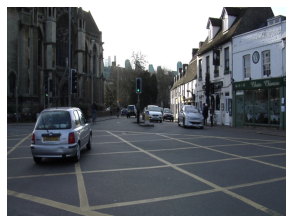

In [8]:
# let's take a look at one of the images
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [9]:
# get label file from image file name by adding "_P"
get_y_fn = lambda x:path_lbl/f'{x.stem}_P{x.suffix}'

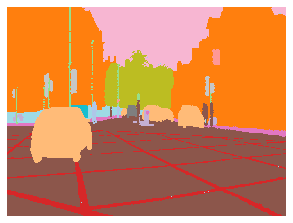

In [10]:
# open the image but use a different function, open_mask, in order to open integers
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [11]:
# look at the data inside the mask
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[ 4,  4,  4,  ..., 21, 21, 21],
          [ 4,  4,  4,  ..., 21, 21, 21],
          [ 4,  4,  4,  ..., 21, 21, 21],
          ...,
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17]]]))

In [12]:
# integers have corresponding labels (codes) that tell us what the pixel in the mask represents (ex. the 4 is a building and so the pixels that have 4 represent a part of a building)
codes = np.loadtxt(path/'codes.txt', dtype=str)
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

### **Datasets**

In [13]:
size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 11438MB of GPU RAM free


In [15]:
src = (SegmentationItemList.from_folder(path_img) # image files in folder
        .split_by_fname_file('../valid.txt') # we don't want to choose validation set randomly (bc images are video frames); we are given a text file with the names of the images that should be in the validation set
        .label_from_func(get_y_fn, classes=codes)) # create labels using the function we just created; codes tell us what those numbers in the integer tensor mean

In [16]:
data = (src.transform(get_transforms(), size=size, tfm_y=True) # data augmentation; need to transform the image AND the mask accordingly
        .databunch(bs=bs) # smaller batch size because we are creating a classifier for every pixel -> more GPU required
        .normalize(imagenet_stats)) 

/usr/local/lib/python3.7/dist-packages/fastai/vision/transform.py:247: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  return _solve_func(B,A)[0][:,0]


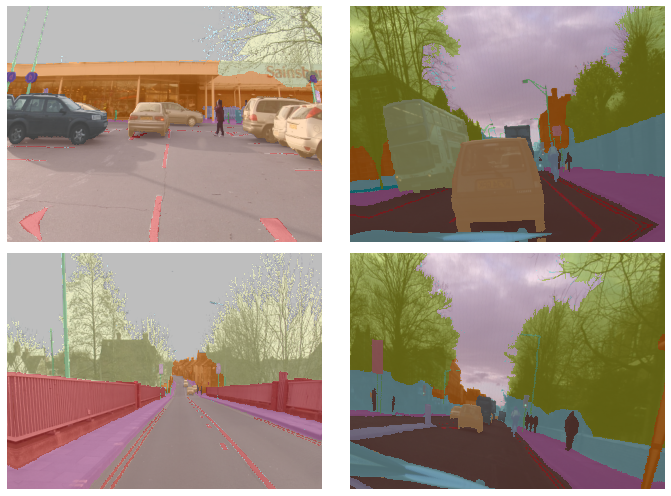

In [18]:
data.show_batch(2, figsize=(10,7))

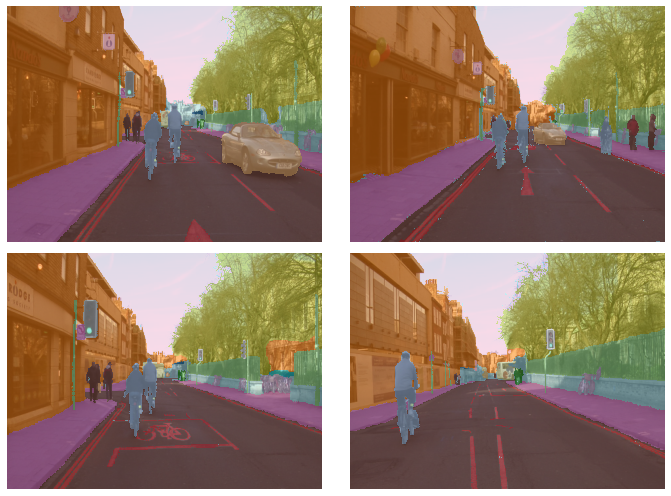

In [19]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

### **Model**

In [21]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
  target = target.squeeze(1)
  mask = target != void_code
  return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [23]:
metrics=acc_camvid

In [ ]:
wd=1d-2